In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization, Embedding, LSTM, Dropout, Dense
from tensorflow.keras import Model, Sequential
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/labeling_arya.csv')
df.drop('preprocessed', axis=1, inplace=True)
df

,date,comment,symbol,label_1,label_2
0,"16 Dec 22, 13:02",SAHAM-SAHAM MENARIK SESI 1 16 DESEMBER\n\n$BEB...,TRGU,0,0
1,"14 Dec 22, 23:27",sy udah nunggu 5 bulan ga terbang2 $TRGU😷😷,TRGU,1,0
2,"14 Dec 22, 14:51",$TRGU besok terbang 🚀,TRGU,2,0
3,"12 Dec 22, 08:21","$TRGU\nPlan lengkap ada di channel telegram, K...",TRGU,0,1
4,"11 Dec 22, 22:16",$TRGU\n\nBaru IPO bbrp bulan lalu. Secara tekn...,TRGU,1,0
...,...,...,...,...,...
128,"2 Oct 22, 09:26",Hanya utk yg mau scalping aja\n\nmendengar 1x ...,TRGU,0,1
129,"30 Sep 22, 09:06","$TRGU uda sell, nga ada harapan saham ginian, ...",TRGU,1,0
130,"29 Sep 22, 14:47",$TRGU,TRGU,0,0
131,"29 Sep 22, 14:45",$TRGU besok jumat berkah 🚀🙏,TRGU,0,0


In [4]:
df2 = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/labelling_husain.csv')
df2 = df2.dropna()
df2['label_1'] = df2['label_1'].astype(int)
df2['label_2'] = df2['label_2'].astype(int)
df2

,date,comment,symbol,label_1,label_2
0,"16 Dec 22, 11:10",Penyampaian Bukti Iklan Hasil RUPS [FISH],FISH,0,0
1,"16 Dec 22, 09:40",Perubahan Pengurus [FISH],FISH,0,0
2,"16 Dec 22, 09:20",Ringkasan Risalah Rapat Umum Para Pemegang Sah...,FISH,0,0
3,"16 Dec 22, 08:26",FKS Multi Agro (FISH) Raih Pinjaman Rp250 Mili...,FISH,2,0
4,"16 Dec 22, 08:25",PT FKS Multi Agro Tbk (FISH) Raih Pinjaman Rp2...,FISH,2,0
...,...,...,...,...,...
96,"10 Dec 22, 10:11",Proud of you my bro @juliusFang !\r\nMember of...,JARR,2,0
97,"9 Dec 22, 14:22",$JARR toloooong hooo hooo,JARR,0,1
98,"8 Dec 22, 09:34",$JARR compounding loss 😎,JARR,1,0
99,"7 Dec 22, 14:40",$JARR,JARR,0,1


In [5]:
df3 = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/STTP_label.csv')
df3

,date,comment,symbol,label_1,label_2
0,"13 Dec 22, 16:40",Penyampaian Materi Public Expose - Tahunan [STTP],STTP,0,0
1,"12 Dec 22, 15:10",Laporan Bulanan Registrasi Pemegang Efek [STTP],STTP,0,0
2,"4 Dec 22, 12:46",$ADES Q3 review\r\n\r\n\r\nTag konsumer:\r\n$S...,STTP,0,1
3,"2 Dec 22, 16:40",Rencana Penyelenggaraan Public Expose - Tahuna...,STTP,0,0
4,"25 Nov 22, 17:15",Tag $ICBP $STTP $ENAK $UNVR $MAPB,STTP,0,1
5,"18 Nov 22, 09:20",Penunjukan/Perubahan Kantor Akuntan Publik dan...,STTP,0,0
6,"8 Nov 22, 15:40",Laporan Bulanan Registrasi Pemegang Efek [STTP],STTP,0,0
7,"4 Nov 22, 18:06","$BSSR melihat pergerakannya,,yg gitu2 aja apak...",STTP,0,1
8,"31 Oct 22, 12:02",@bamzat maksudnya biar jadi $STTP $WINS $ARTO ...,STTP,0,1
9,"31 Oct 22, 12:00",@Paquito sama aja gan beli $STTP nanti dikriti...,STTP,0,0


In [6]:
df4 = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/STAA_label.csv')
df4

,date,comment,symbol,label_1,label_2
0,"16 Dec 22, 13:19",$STAA selama masih ada potensi positif di haka...,STAA,2,0
1,"16 Dec 22, 11:21",$LSIP $BWPT $SSMS $STAA B35 apa kabar $BOSS ?g...,STAA,0,1
2,"16 Dec 22, 08:38",Harga kontrak Crude Palm Oil (CPO) di Bursa Ma...,STAA,1,0
3,"15 Dec 22, 08:17",$STAA membuka peluang membentuk tren naik sete...,STAA,2,0
4,"14 Dec 22, 22:53","JAKARTA, https://cutt.ly/H0xp1zp - Harga kontr...",STAA,2,0
...,...,...,...,...,...
126,"17 Nov 22, 18:54","@alvans semoga $STAA kebagian jatah ekspor y,b...",STAA,2,0
127,"17 Nov 22, 15:34","Nah loh,Eropa bisa ga kebagian stok CPO nih😀\r...",STAA,0,0
128,"17 Nov 22, 13:17",$STAA sesi II serok lagii $IHSG,STAA,2,0
129,"17 Nov 22, 10:05","$STAA Bukukan Laba Bersih Rp 1,01 Triliun pada...",STAA,2,0


In [7]:
df5 = pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/ICBP_MLBI_labeled.csv')
df5.rename(columns={'label 1':'label_1','label 2':'label_2'}, inplace=True)
df5

,date,comment,symbol,label_1,label_2
0,"15 Dec 22, 16:48",POLL\r\nSusu paling enak apa gan? Vox Populi V...,ICBP,0,0
1,"15 Dec 22, 15:00",$ICBP,ICBP,0,0
2,"15 Dec 22, 10:25",$GOTO main di 90 an aja ya kamu g usah kemana2...,ICBP,0,0
3,"14 Dec 22, 19:45",Info Singkat saham untuk 15 Desember 2022 (buk...,ICBP,0,0
4,"14 Dec 22, 19:41",@godbless @handusene sejak periode lockup open...,ICBP,1,0
...,...,...,...,...,...
177,"8 Nov 22, 18:07",Info Singkat saham untuk 9 November 2022 (buka...,CPIN,0,0
178,"8 Nov 22, 00:00",$CPIN yuk sanggup yuk 6500,CPIN,0,0
179,"7 Nov 22, 15:20",Laporan Bulanan Registrasi Pemegang Efek [CPIN],CPIN,0,0
180,"7 Nov 22, 10:57",$JPFA $CPIN $MAIN\r\n\r\nSektor poultry adalah...,CPIN,2,0


In [8]:
df6= pd.read_csv('/kaggle/input/daily-stock-sentiment-analysis/labeling_shortir.csv')
df6.loc[df6['label_2'] == 2] = 0
df6['label_1'] = df6['label_1'].astype(int)
df6['label_2'] = df6['label_2'].astype(int)
df6

,date,comment,symbol,label_1,label_2
0,"16 Dec 22, 13:07",@SyamFadil pantes ya gk ada yang ngerekrut ter...,CLEO,1,1
1,"16 Dec 22, 11:54",@RadenRama sepertinya sih kenalan bandarnya $C...,CLEO,1,0
2,"16 Dec 22, 11:01","$CLEO belum ada tanda pembalikan arah, masih t...",CLEO,1,0
3,"16 Dec 22, 10:35","$CLEO cukai plastik mulai berlaku di 2023, apa...",CLEO,0,0
4,"16 Dec 22, 09:47","@igpys tuh kan bener, $CLEO otw balik ke 450",CLEO,1,0
...,...,...,...,...,...
194,"11 Nov 22, 06:59","$CPO saatnya melambung, yang mana juga akan me...",DSNG,2,0
195,"10 Nov 22, 18:19",$AALI CPO mengapa runtuh?\r\n\r\n$LSIP $TAPG $...,DSNG,0,0
196,"10 Nov 22, 17:25",Dharma Satya Nusantara (DSNG) Perkirakan Harga...,DSNG,2,0
197,"10 Nov 22, 12:51",~Singapura 🇸🇬 Siap Gelontorkan Dana untuk Atas...,DSNG,2,0


In [9]:
df_fix = pd.concat([df,df2,df3,df4,df5,df6])
df_fix.reset_index(inplace=True,drop=True)

df_fix

,date,comment,symbol,label_1,label_2
0,"16 Dec 22, 13:02",SAHAM-SAHAM MENARIK SESI 1 16 DESEMBER\n\n$BEB...,TRGU,0,0
1,"14 Dec 22, 23:27",sy udah nunggu 5 bulan ga terbang2 $TRGU😷😷,TRGU,1,0
2,"14 Dec 22, 14:51",$TRGU besok terbang 🚀,TRGU,2,0
3,"12 Dec 22, 08:21","$TRGU\nPlan lengkap ada di channel telegram, K...",TRGU,0,1
4,"11 Dec 22, 22:16",$TRGU\n\nBaru IPO bbrp bulan lalu. Secara tekn...,TRGU,1,0
...,...,...,...,...,...
766,"11 Nov 22, 06:59","$CPO saatnya melambung, yang mana juga akan me...",DSNG,2,0
767,"10 Nov 22, 18:19",$AALI CPO mengapa runtuh?\r\n\r\n$LSIP $TAPG $...,DSNG,0,0
768,"10 Nov 22, 17:25",Dharma Satya Nusantara (DSNG) Perkirakan Harga...,DSNG,2,0
769,"10 Nov 22, 12:51",~Singapura 🇸🇬 Siap Gelontorkan Dana untuk Atas...,DSNG,2,0


In [10]:
df_fix.drop_duplicates(subset=['comment'], inplace=True)

In [11]:
df_fix['label_2'].value_counts()

0    571
1    163
Name: label_2, dtype: int64

In [12]:
with open('/kaggle/input/daily-stock-sentiment-analysis/slangwords.txt', 'rt') as file_1:
    slangwords = {}
    for line in file_1:
        (key, val) = line.rstrip().split(":")
        slangwords[key] = val

with open('/kaggle/input/daily-stock-sentiment-analysis/stopwords_v2.txt') as file_2:
    stopwords = [item.rstrip() for item in list(file_2)]

In [13]:
## Create A New Stopwords
new_stop_words = ['saham', 'perusahaan', 'yg', 'harga','tahun']

## Merge Stopwords
stop_words = stopwords + new_stop_words
stop_words = list(set(stop_words))
print('Out Final Stopwords')
print(len(stop_words), stop_words)

Out Final Stopwords
400 ['perusahaan', 'pernah', 'beginikah', 'setidaknya', 'manakala', 'yakni', 'kapankah', 'masih', 'terjadi', 'sudah', 'amat', 'kalau', 'menyatakan', 'berapalah', 'sama', 'salah', 'kembali', 'mulai', 'supaya', 'akan', 'lagi', 'melalui', 'atas', 'ia', 'meski', 'bilakah', 'kata', 'sedemikian', 'kala', 'sebaliknya', 'kok', 'karenanya', 'mana', 'serupa', 'hingga', 'bisa', 'percuma', 'begitupun', 'betulkah', 'agaknya', 'ini', 'tetapi', 'akankah', 'kitalah', 'an', 'waduh', 'akhirnya', 'hendaklah', 'terlebih', 'sedang', 'dini', 'katanya', 'bagaimanapun', 'karena', 'sebenarnya', 'paparnya', 'sebetulnya', 'harga', 'demikian', 'sesama', 'lalu', 'siapapun', 'saat', 'anda', 'oleh', 'merupakan', 'per', 'sebelum', 'para', 'daripada', 'kinilah', 'bila', 'suatu', 'warta', 'entah', 'pun', 'segera', 'sedikit', 'sekarang', 'pastilah', 'cukup', 'semasih', 'sebabnya', 'macam', 'mau', 'maupun', 'kenapa', 'setiap', 'ternyata', 'mengapa', 'sepertinya', 'biasanya', 'tiap', 'tidakkah', 'semua

In [14]:
def textproses(text):
  
  # Menghilangkan nama saham
  text = re.sub("\$[A-Z]{4}| [A-Z]{4} ", " ", text)

  # Mengubah text ke Lowercase agar semua data seragam
  text = text.lower()

  # Menghilangkan @/Mention karena pada berita palsu ada mention akun twitter
  text = re.sub("@[A-Za-z0-9]+", " ", text)

  # Menghilangkan #/Hashtag untuk mengantisipasi karena berita palsu mengambil dari twitter
  text = re.sub("#[A-Za-z0-9_]+", " ", text)
  
  # Menghilangkan \n untuk antisipasi
  text = re.sub(r"\n", " ",text)

  # Menghilangkan Whitespace untuk antisipasi
  text = text.strip()

  # Menghilangkan Link dikarenakan berita palsu terdapat link ke artikel lain
  #text = re.sub(r"http\S+", " ", text)
  #text = re.sub(r"www.\S+", " ", text)

  # Menghilangkan yang Bukan Huruf seperti Emoji, Simbol Matematika (seperti μ), dst untuk antisipasi
  text = re.sub("[^A-Za-z\s']", " ", text)

  # Melakukan Tokenisasi
  tokens = word_tokenize(text)

  # Menghilangkan Stopwords
  text = ' '.join([word for word in tokens if word not in stopwords])

  # Melakukan lemmatizing
  text = " ".join(slangwords.get(word, word) for word in text.split())
  
  return text

In [15]:
df_fix['text_processed'] = df_fix['comment'].apply(lambda x: textproses(str(x)))

In [16]:
df_fix

,date,comment,symbol,label_1,label_2,text_processed
0,"16 Dec 22, 13:02",SAHAM-SAHAM MENARIK SESI 1 16 DESEMBER\n\n$BEB...,TRGU,0,0,saham saham menarik desember stock split bulli...
1,"14 Dec 22, 23:27",sy udah nunggu 5 bulan ga terbang2 $TRGU😷😷,TRGU,1,0,saya udah nunggu bulan tidak terbang
2,"14 Dec 22, 14:51",$TRGU besok terbang 🚀,TRGU,2,0,besok terbang
3,"12 Dec 22, 08:21","$TRGU\nPlan lengkap ada di channel telegram, K...",TRGU,0,1,plan lengkap channel telegram klik linknya bio...
4,"11 Dec 22, 22:16",$TRGU\n\nBaru IPO bbrp bulan lalu. Secara tekn...,TRGU,1,0,bbrp bulan teknikal downtrend support cocok di...
...,...,...,...,...,...,...
766,"11 Nov 22, 06:59","$CPO saatnya melambung, yang mana juga akan me...",DSNG,2,0,cpo melambung menaikkan harga saham perkebunan...
767,"10 Nov 22, 18:19",$AALI CPO mengapa runtuh?\r\n\r\n$LSIP $TAPG $...,DSNG,0,0,cpo runtuh dll
768,"10 Nov 22, 17:25",Dharma Satya Nusantara (DSNG) Perkirakan Harga...,DSNG,2,0,dharma satya nusantara dsng perkirakan harga c...
769,"10 Nov 22, 12:51",~Singapura 🇸🇬 Siap Gelontorkan Dana untuk Atas...,DSNG,2,0,singapura siap gelontorkan dana atasi perubaha...


In [63]:
X_test == 1

681    False
227    False
626    False
286    False
183    False
       ...  
504    False
126    False
505    False
79     False
288    False
Name: text_processed, Length: 147, dtype: bool

In [24]:
df_fix['comment'][3]

'$TRGU\nPlan lengkap ada di channel telegram, Klik saja linknya di bio ya. Disana ada menu ODT, ARB hunter, swing dan live trade. Free tidak ada embel" apapun😚😚'

In [23]:
df_fix['text_processed'][3]


'plan lengkap channel telegram klik linknya bio disana menu odt arb hunter swing live trade free embel apapun'

In [25]:
from sklearn.model_selection import train_test_split


In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_fix.text_processed, 
                                                    df_fix.label_2, 
                                                    test_size=0.2,
                                                    random_state=20)

print('Train Size : ', len(X_train))
print('Test Size  : ', len(X_test))

Train Size :  587
Test Size  :  147


In [27]:
count_vect = CountVectorizer(stop_words = stop_words)

count_vect.fit(X_train)
X_train_vect = count_vect.transform(X_train)
X_test_vect = count_vect.transform(X_test)

In [38]:
X_train

718    info singkat saham november bukan rekomendasi ...
355    harga cpo rebound akhiri pelemahan empat hari ...
513                        ihsg un dressing meme vesting
618    kebanyakan orang pakar investasi pesimis reses...
388    bukukan laba bersih rp triliun kuartal iii jak...
                             ...                        
233                              kurang cuan bantu bosku
238                                                  tag
287    pergerakan harga cpo sepekan bergantung rilisn...
498    saham calon turnaround definisi turnaround per...
373                      emiten besar yaak perusahaannya
Name: text_processed, Length: 587, dtype: object

In [28]:
X_train_vect

<587x5093 sparse matrix of type '<class 'numpy.int64'>'
	with 13355 stored elements in Compressed Sparse Row format>

In [29]:
from sklearn.neighbors import KNeighborsClassifier

model_knn_count_vect = KNeighborsClassifier(n_neighbors=7)
model_knn_count_vect.fit(X_train_vect, y_train)

KNeighborsClassifier(n_neighbors=7)

In [44]:
from sklearn.metrics import classification_report

y_pred_train = model_knn_count_vect.predict(X_train_vect)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.85      0.86      0.86       465
           1       0.45      0.43      0.44       122

    accuracy                           0.77       587
   macro avg       0.65      0.65      0.65       587
weighted avg       0.77      0.77      0.77       587



In [45]:
y_pred_test = model_knn_count_vect.predict(X_test_vect)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.75      0.68      0.71       106
           1       0.33      0.41      0.37        41

    accuracy                           0.61       147
   macro avg       0.54      0.55      0.54       147
weighted avg       0.63      0.61      0.62       147



In [46]:
new_texts = ['beli saham #JPFA to the moon',
             'rekomendasi saham setiap hari di link https://telegram.com/.. #JPFA #GOTO #BBCA #BMRI #GOTO']

new_texts_count_vect_sw = count_vect.transform(new_texts)
model_knn_count_vect.predict(new_texts_count_vect_sw)

array([0, 0])

In [47]:
X_train_vect = X_train_vect.toarray()
X_test_vect = X_test_vect.toarray()

In [48]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(X_train_vect, y_train)

GaussianNB()

In [49]:
y_pred_train = naive_bayes.predict(X_train_vect)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      0.88      0.93       465
           1       0.68      1.00      0.81       122

    accuracy                           0.90       587
   macro avg       0.84      0.94      0.87       587
weighted avg       0.93      0.90      0.91       587



In [50]:
y_pred_test = naive_bayes.predict(X_test_vect)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.79      0.58      0.67       106
           1       0.36      0.61      0.45        41

    accuracy                           0.59       147
   macro avg       0.57      0.59      0.56       147
weighted avg       0.67      0.59      0.61       147



In [30]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(X_train_vect, y_train)

RandomForestClassifier()

In [31]:
from sklearn.pipeline import Pipeline
text_preprocessing = Pipeline([('Vect', CountVectorizer())])

In [32]:
from sklearn.compose import ColumnTransformer

preprocess = ColumnTransformer([
                            ('text_preprocessing', text_preprocessing, ['comment'])
                        ])


params {'clf__max_depth': 19}
score 0.1487993487993488


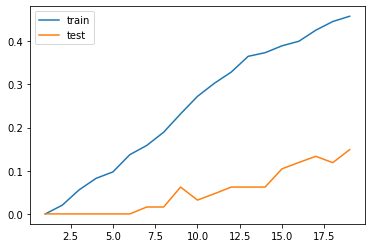

In [33]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import seaborn as sns

rf_pipe = Pipeline(steps=[
            ('clf', RandomForestClassifier(random_state=17)
            )])

def isolate():
    grid = GridSearchCV(
        estimator=rf_pipe,
        scoring=make_scorer(score_func=f1_score, pos_label=1),
        param_grid={
            'clf__max_depth': np.arange(1,20,1)
        },
        return_train_score=True,
        n_jobs=-1
    )
    grid.fit(X=X_train_vect, y=y_train)

    print("params", grid.best_params_)
    print("score", grid.best_score_)

    sns.lineplot(
        x=grid.cv_results_['param_clf__max_depth'],
        y=grid.cv_results_['mean_train_score'],
        label="train"
    )
    sns.lineplot(
        x=grid.cv_results_['param_clf__max_depth'],
        y=grid.cv_results_['mean_test_score'],
        label="test"
    )
    
isolate()

[0 1]
[0.14498244 0.36607617 0.06942099 0.46       0.22089756 0.30063468
 0.3428205  0.19       0.12124938 0.66695238 0.2877187  0.19
 0.32345097 0.22352941 0.04316775 0.0725     0.35333421 0.0237535
 0.48233028 0.26       0.04209804 0.0530439  0.35333421 0.64
 0.46971709 0.01807692 0.05892216 0.09661152 0.33863355 0.73
 0.14363655 0.35333421 0.23       0.15354945 0.13057539 0.52071146
 0.55       0.7        0.264      0.37061491 0.16617893 0.15572103
 0.14244705 0.01       0.56       0.26838663 0.35333421 0.08605339
 0.21       0.09235778 0.53       0.35333421 0.3179932  0.34105263
 0.38594732 0.22       0.24805997 0.18284361 0.03634682 0.08965338
 0.30445893 0.01217965 0.33452713 0.18266667 0.24595756 0.25738523
 0.33084944 0.155      0.13527778 0.03       0.443125   0.46422437
 0.12583615 0.20336538 0.00951299 0.01951299 0.15       0.35333421
 0.06849152 0.29919414 0.01       0.1543245  0.13057539 0.35333421
 0.71       0.36937724 0.03353757 0.34172707 0.16773801 0.15539943
 0.3375 

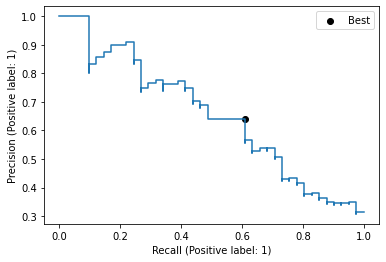

In [34]:
from sklearn.metrics import make_scorer, PrecisionRecallDisplay, precision_recall_curve

def isolate():
    print(random_forest.classes_)

    y_test_prob = random_forest.predict_proba(X=X_test_vect)[:,1]
    print(y_test_prob)

    precision, recall, thresholds = precision_recall_curve(
        y_true=y_test, probas_pred=y_test_prob,
        pos_label=1)

    ax = plt.gca()

    disp = PrecisionRecallDisplay(
        precision=precision, recall=recall,
        pos_label=1)
    disp.plot(ax=ax)

    fscore = 2 * (precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    
    plt.legend()
    plt.show()
    
isolate()

In [80]:
y_pred_train = random_forest.predict(X_train_vect)
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       465
           1       1.00      0.92      0.96       122

    accuracy                           0.98       587
   macro avg       0.99      0.96      0.97       587
weighted avg       0.98      0.98      0.98       587



In [81]:
y_pred_test = random_forest.predict(X_test_vect)
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.78      0.97      0.87       106
           1       0.80      0.29      0.43        41

    accuracy                           0.78       147
   macro avg       0.79      0.63      0.65       147
weighted avg       0.79      0.78      0.74       147



In [36]:
y_pred_test = random_forest.predict_proba(X_test_vect)[:,1]>=0.353334
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       106
           1       0.64      0.61      0.62        41

    accuracy                           0.80       147
   macro avg       0.75      0.74      0.74       147
weighted avg       0.79      0.80      0.79       147



In [37]:
new_texts = ['beli saham #JPFA to the moon',
             'news update november terakhir wall street melemah hari beruntun harga minyak dunia naik usai lockdown china diperlonggar jokowi melakukan banding gugatan wto kebijakan larangan ekspor nikel meraih banking award lembaga penjamin simpanan ekspansi bisnis serius kembangkan bisnis pengolahan pakan ternak catatkan rugi bersih rp m kuartal iii memburuk dibanding tahun catatkan laba bersih rp m menderita rugi bersih rp m kuartal iii membengkak yoy miranda goeltom copot kursi komisaris']

new_texts_count_vect_sw = count_vect.transform(new_texts)
random_forest.predict(new_texts_count_vect_sw)

array([0, 1])

In [118]:
import joblib
import json

with open('random_forest.pkl', 'wb') as file_1:
  joblib.dump(random_forest, file_1)

with open('count_vect.pkl', 'wb') as file_2:
  joblib.dump(count_vect, file_2)

